In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms

import lightning as pl

import warnings
warnings.filterwarnings("ignore")

In [64]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
transform=transforms.Compose([
    transforms.ToTensor(),
])
# transform = transforms.Compose([transforms.Grayscale(3), transforms.ToTensor(), transforms.Resize([24,24])])

# we ignore object detection annotations by setting target_transform to return 0
train_dataset = MNIST(
    "data",
    download=True,
    transform=transform,
    train=True
)

test_dataset = MNIST(
    "data",
    download=True,
    transform=transform,
    train=False
)

BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
)

In [34]:
# from pl_bolts.models.autoencoders.components import (
#     resnet18_decoder,
#     resnet18_encoder,
# )

# class VAE(pl.LightningModule):
#     def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
#         super().__init__()

#         self.save_hyperparameters()

#         # encoder, decoder
#         self.encoder = resnet18_encoder(False, False)
#         self.decoder = resnet18_decoder(
#             latent_dim=latent_dim,
#             input_height=input_height,
#             first_conv=False,
#             maxpool1=False
#         )

#         # distribution parameters
#         self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
#         self.fc_var = nn.Linear(enc_out_dim, latent_dim)

#         # for the gaussian likelihood
#         self.log_scale = nn.Parameter(torch.Tensor([0.0]))

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=1e-4)

#     def gaussian_likelihood(self, x_hat, logscale, x):
#         scale = torch.exp(logscale)
#         mean = x_hat
#         dist = torch.distributions.Normal(mean, scale)

#         # measure prob of seeing image under p(x|z)
#         log_pxz = dist.log_prob(x)
#         return log_pxz.sum(dim=(1, 2, 3))

#     def kl_divergence(self, z, mu, std):
#         # --------------------------
#         # Monte carlo KL divergence
#         # --------------------------
#         # 1. define the first two probabilities (in this case Normal for both)
#         p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
#         q = torch.distributions.Normal(mu, std)

#         # 2. get the probabilities from the equation
#         log_qzx = q.log_prob(z)
#         log_pz = p.log_prob(z)

#         # kl
#         kl = (log_qzx - log_pz)
#         kl = kl.sum(-1)
#         return kl

#     def training_step(self, batch, batch_idx):
#         x, _ = batch
#         # encode x to get the mu and variance parameters
#         x_encoded = self.encoder(x)
#         mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

#         # sample z from q
#         std = torch.exp(log_var / 2)
#         q = torch.distributions.Normal(mu, std)
#         z = q.rsample()

#         # decoded
#         x_hat = self.decoder(z)

#         # reconstruction loss
#         recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

#         # kl
#         kl = self.kl_divergence(z, mu, std)

#         # elbo
#         elbo = (kl - recon_loss)
#         elbo = elbo.mean()

#         self.log_dict({
#             'elbo': elbo,
#             'kl': kl.mean(),
#             'recon_loss': recon_loss.mean(),
#             'reconstruction': recon_loss.mean(),
#             'kl': kl.mean(),
#         })

#         return elbo

In [67]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
from typing import Optional
from collections import namedtuple

CustomTransform = namedtuple("CustomTransform", ["custom_resize", "custom_normalize"])

class Stack(nn.Module):
    def __init__(self, channels, height, width):
        super(Stack, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width

    def forward(self, x):
        return x.view(x.size(0), self.channels, self.height, self.width)


class VAE(pl.LightningModule):
    def __init__(self,
                 latent_dim:int,
                 input_height:int,
                 input_width:int,
                 input_channels:int,
                 lr: float,
                 batch_size: int,
                 save_path: Optional[str] = None, **kwargs):
        """Init function for the VAE
        Args:
        latent_dim (int): Latent Hidden Size
        reconstruction loss vs KL-Divergence Loss
        lr (float): Learning Rate, will not be used if auto_lr_find is used.
        dataset (Optional[str]): Dataset to used
        save_path (Optional[str]): Path to save images
        """

        super().__init__()
        self.latent_dim = latent_dim

        self.save_hyperparameters()

        self.lr = lr

        self.batch_size = batch_size

        ENC_OUT_DIM = 128

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels*input_height*input_width, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, ENC_OUT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
            nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
            nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
            nn.Linear(392, input_channels*input_height*input_width),
            nn.Sigmoid(),
            Stack(input_channels, input_height, input_width),
        )

        self.hidden2mu = nn.Linear(ENC_OUT_DIM, latent_dim)
        self.hidden2log_var = nn.Linear(ENC_OUT_DIM, latent_dim)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))


    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden2mu(hidden)
        log_var = self.hidden2log_var(hidden)
        return mu, log_var

    def decode(self, x):
        x = self.decoder(x)
        return x

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick to allow gradients to backpropagate from the
        # stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.randn_like(sigma)
        return mu + sigma*z

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)

        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self, x):

        mu, log_var = self.encode(x)
        std = torch.exp(log_var / 2)

        #Sample from distribution
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        #Push sample through decoder
        x_hat = self.decode(z)

        return mu, std, z, x_hat


    def training_step(self, batch, batch_idx):

        x, _ = batch

        mu, std, z, x_hat = self.forward(x)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        #expectation under z of the kl divergence between q(z|x) and
        #a standard normal distribution of the same shape
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log('train_kl_loss', kl.mean(), on_step=True,
                 on_epoch=True, prog_bar=False)
        self.log('train_recon_loss', recon_loss.mean(), on_step=True,
                 on_epoch=True, prog_bar=False)
        self.log('train_loss', elbo, on_step=True,
                 on_epoch=True, prog_bar=True)

        # train_images = make_grid(x[:16]).cpu().numpy()
        return elbo

    def validation_step(self, batch, batch_idx):

        x, _ = batch

        mu, std, z, x_hat = self.forward(x)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        #expectation under z of the kl divergence between q(z|x) and
        #a standard normal distribution of the same shape
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = kl - recon_loss
        elbo = elbo.mean()

        self.log('val_kl_loss', kl.mean(), on_step=False, on_epoch=True)
        self.log('val_recon_loss', recon_loss.mean(), on_step=False, on_epoch=True)
        self.log('val_loss', elbo, on_step=False, on_epoch=True)

        self.logger.experiment.add_image('Normalized Inputs', make_grid(x[:8]))


        return x_hat, elbo

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=(self.lr or self.learning_rate))
        lr_scheduler = ReduceLROnPlateau(optimizer,)
        return {
            "optimizer": optimizer, "lr_scheduler": lr_scheduler,
            "monitor": "train_loss"
        }

    def interpolate(self, x1, x2):
        assert x1.shape == x2.shape, "Inputs must be of the same shape"
        if x1.dim() == 3:
            x1 = x1.unsqueeze(0)
        if x2.dim() == 3:
            x2 = x2.unsqueeze(0)
        if self.training:
            raise Exception(
                "This function should not be called when model is still "
                "in training mode. Use model.eval() before calling the "
                "function")
        mu1, lv1 = self.encode(x1)
        mu2, lv2 = self.encode(x2)
        z1 = self.reparametrize(mu1, lv1)
        z2 = self.reparametrize(mu2, lv2)
        weights = torch.arange(0.1, 0.9, 0.1)
        intermediate = [self.decode(z1)]
        for wt in weights:
            inter = (1.-wt)*z1 + wt*z2
            intermediate.append(self.decode(inter))
        intermediate.append(self.decode(z2))
        out = torch.stack(intermediate, dim=0).squeeze(1)
        return out, (mu1, lv1), (mu2, lv2)

    @staticmethod
    def custom_transform(normalization):
        return None, None


In [68]:
model = VAE(input_height=28, input_width=28, input_channels=1, latent_dim=128, batch_size=BATCH_SIZE, lr=1e-3)
trainer = pl.Trainer(max_epochs=5, accelerator="mps")
trainer.fit(model, trainloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 427 K 
1 | decoder        | Sequential | 428 K 
2 | hidden2mu      | Linear     | 16.5 K
3 | hidden2log_var | Linear     | 16.5 K
----------------------------------------------
889 K     Trainable params
0         Non-trainable params
889 K     Total params
3.558     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [72]:
device = torch.device("mps")
model.to(device)
model.eval()
X_embedded, y_true = [], []
with torch.no_grad():
    for (x, y) in tqdm(trainloader):
        x, y = x.to(device), y.to(device)
        mu, log_var = model.encode(x)
        X_embedded.append(mu.detach().cpu().numpy())
        y_true.append(y.detach().cpu().numpy())
        
X_embedded, y_true = np.concatenate(X_embedded), np.concatenate(y_true)

100%|██████████| 938/938 [00:03<00:00, 252.98it/s]


<Axes: >

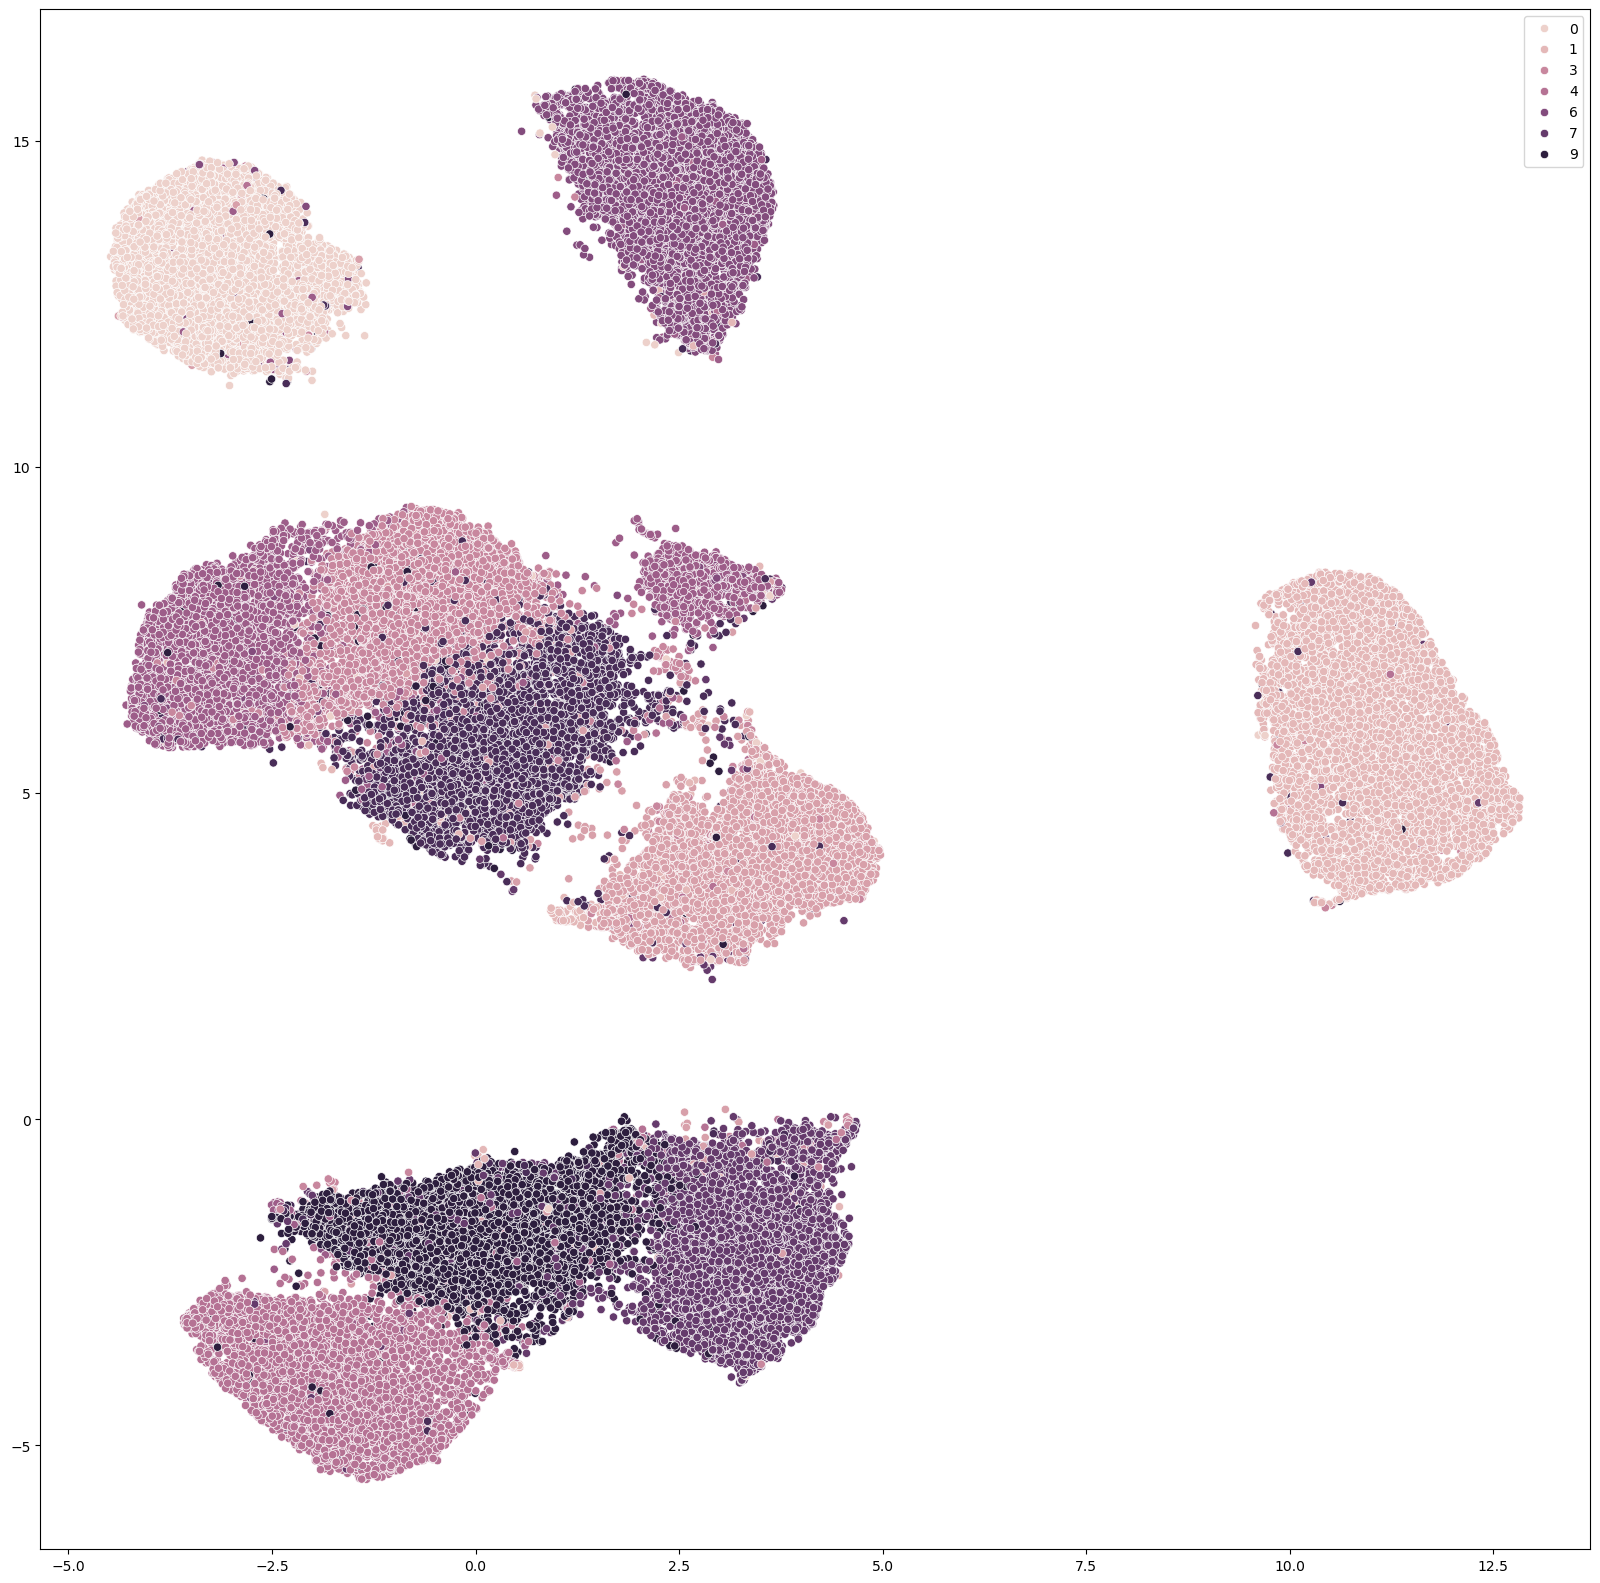

In [75]:
import umap

mapper = umap.UMAP(n_components=2)
manifold = mapper.fit_transform(X_embedded)

fig, ax = plt.subplots(1,1,figsize=(20,20))
sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=y_true, ax=ax)